In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el preprocesado y escalado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Para la construcción del modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Para evaluar el rendimiento
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.utils import resample

In [2]:
# -------------------------
# 1. Carga de datos
# -------------------------
df = pd.read_csv("equipment_anomaly_data.csv")
print("Primeras filas del dataset:")
df.head()

Primeras filas del dataset:


,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [4]:
print("\nResumen estadístico:")
df.describe()


Resumen estadístico:


,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [5]:
# -------------------------
# 2. Limpieza de datos
# -------------------------
# Identificamos las columnas categóricas y numéricas
numerical_cols = ['temperature', 'pressure', 'vibration', 'humidity']
categorical_cols = ['equipment', 'location']

print("Número de nulos:") 
print(df.isnull().sum())
print()
print(df['equipment'].value_counts())
print()
print(df['location'].value_counts())
print()
print(df['faulty'].value_counts())
print()

Número de nulos:
temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

faulty
0.0    6905
1.0     767
Name: count, dtype: int64



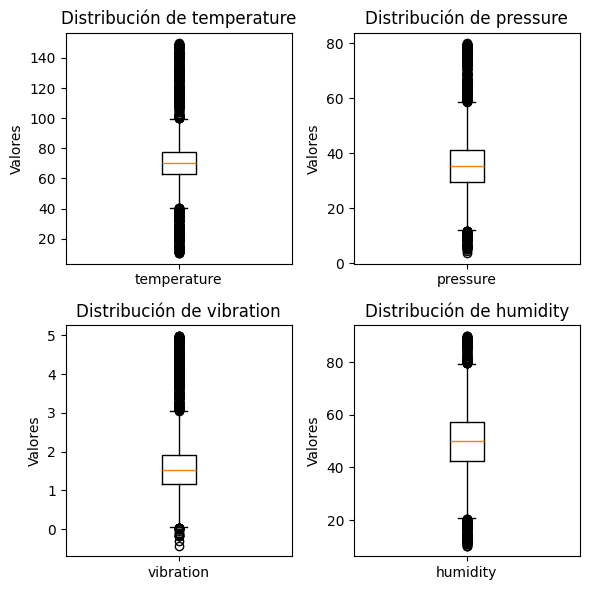

In [6]:
# -------------------------
# 2. Análisis visual de variables
# -------------------------
ig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
axes = axes.flatten() 

for i, var in enumerate(numerical_cols): 
    axes[i].boxplot(df[var], tick_labels=[var]) 
    axes[i].set_title(f'Distribución de {var}') 
    axes[i].set_ylabel('Valores')

for j in range(len(numerical_cols), len(axes)): 
    axes[j].axis('off')

plt.tight_layout() 
plt.show()

In [7]:
# -------------------------
# 2. Preprocesamiento e engeniería de Características
# -------------------------
# Vamos a considerar lo siguiente:
# - Variables numéricas: temperature, pressure, vibration, humidity.
# - Variables categóricas: equipment, location.
# - Variable predictora: faulty (0 o 1).

df = pd.get_dummies(df, columns=['equipment'], prefix='EQ', dtype=int)
df = pd.get_dummies(df, columns=['location'], prefix='LOC', dtype=int)

In [8]:
df['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

In [9]:
X = df.drop("faulty", axis=1)
y = df["faulty"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
df_majority = train_df[train_df['faulty'] == 0]
df_minority = train_df[train_df['faulty' ] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
train_balanced = pd.concat([df_majority, df_minority_upsampled])

X_train = train_balanced.drop(columns=["faulty"])
y_train = train_balanced["faulty"]

In [11]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [12]:
# -------------------------
# 4. Creación y entrenamiento de la red neuronal
# -------------------------
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\jm.blazquezsoriano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Usamos EarlyStopping para evitar sobreajuste y entrenamos
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100


277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7784 - loss: 0.4883 - val_accuracy: 0.8905 - val_loss: 0.2443
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9395 - loss: 0.1754 - val_accuracy: 0.9303 - val_loss: 0.1854
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9475 - loss: 0.1450 - val_accuracy: 0.9371 - val_loss: 0.1510
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9549 - loss: 0.1243 - val_accuracy: 0.9262 - val_loss: 0.1730
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9572 - loss: 0.1237 - val_accuracy: 0.9303 - val_loss: 0.1892
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.1119 - val_accuracy: 0.9416 - val_loss: 0.1602
Epoch 7/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9603 - loss: 0.1127 - val_accuracy: 0.9371 - val_loss: 0.1495
Epoch 8/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9657 - loss: 0.1020 - val_accuracy: 0.9597


Pérdida en test: 0.0890
Exactitud en test: 0.9668
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1382
         1.0       0.78      0.92      0.85       153

    accuracy                           0.97      1535
   macro avg       0.89      0.95      0.91      1535
weighted avg       0.97      0.97      0.97      1535



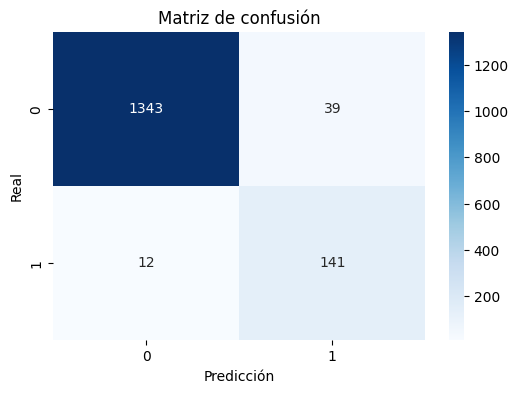

ROC AUC: 0.9813


In [14]:
# -------------------------
# 5. Evaluación del modelo
# -------------------------
# Evaluamos en el conjunto de test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {loss:.4f}")
print(f"Exactitud en test: {accuracy:.4f}")

# Predicciones y reporte de clasificación
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

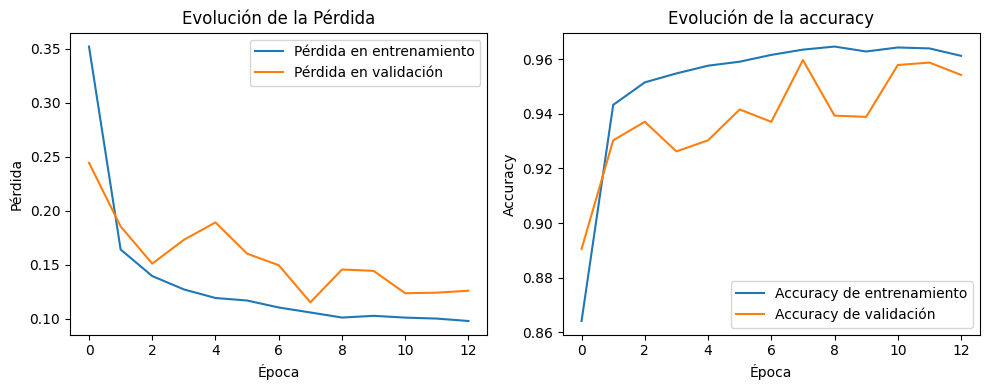

In [15]:
# -------------------------
# 6. Visualización del historial de entrenamiento
# -------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Evolución de la Pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de validación')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución de la accuracy")
plt.legend()

plt.tight_layout()
plt.show()

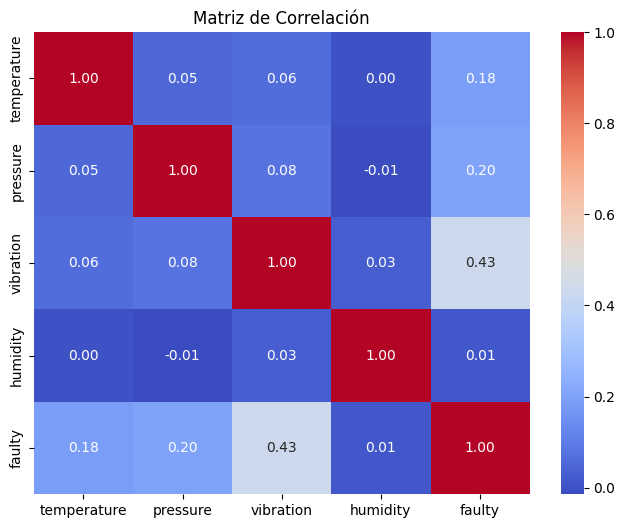

In [20]:
# -------------------------
# ANÁLISIS EXPLORATORIO DE DATOS
# -------------------------
numerical_correlation = ['temperature', 'pressure', 'vibration', 'humidity', 'faulty']
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_correlation].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

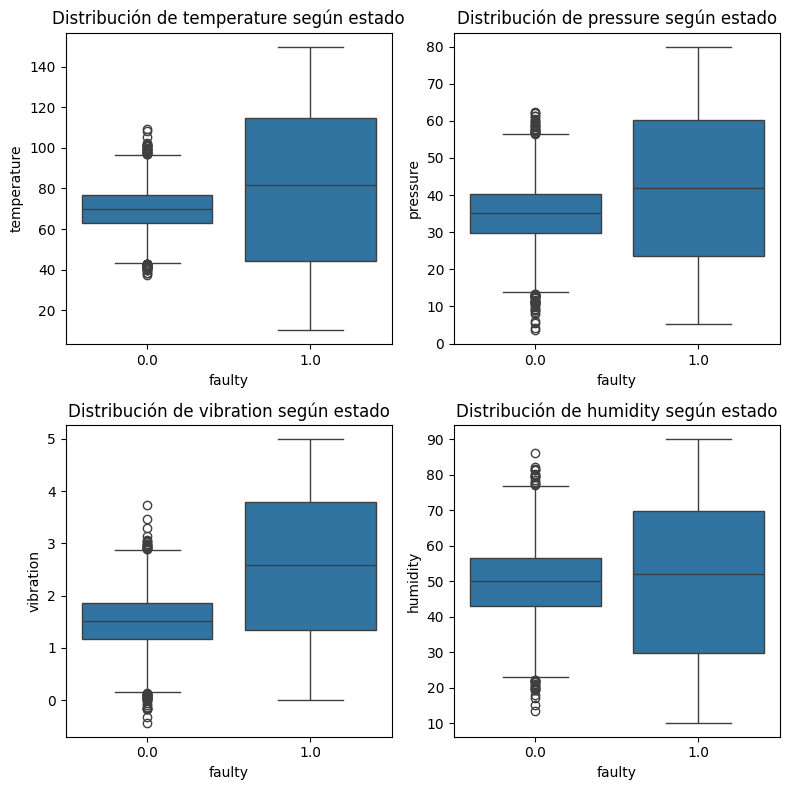

In [39]:
plt.figure(figsize=(8,8))
for i, feature in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.boxplot(x="faulty", y=feature, data=df)
    plt.title(f"Distribución de {feature} según estado")
plt.tight_layout()
plt.show()


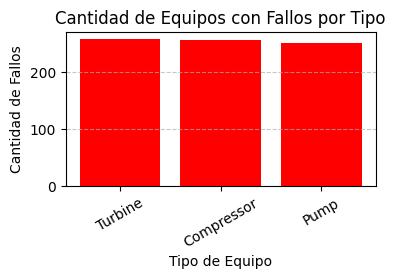

In [42]:
df_fallos = df[df["faulty"] == 1]
fallos_por_equipo = df_fallos["equipment"].value_counts()

plt.figure(figsize=(4,2))
plt.bar(fallos_por_equipo.index, fallos_por_equipo.values, color="red")

plt.xlabel("Tipo de Equipo")
plt.ylabel("Cantidad de Fallos")
plt.title("Cantidad de Equipos con Fallos por Tipo")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


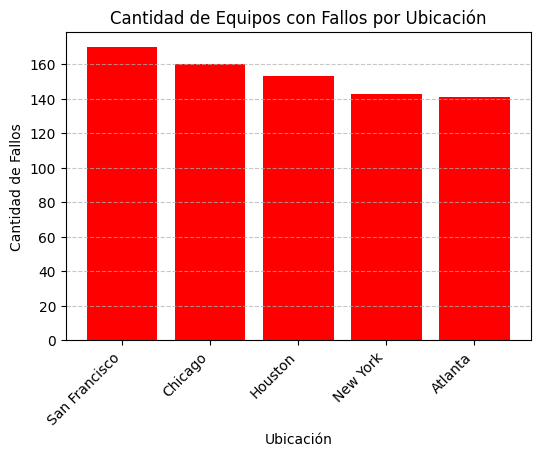

In [45]:
fallos_por_ubicacion = df_fallos["location"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(fallos_por_ubicacion.index, fallos_por_ubicacion.values, color="red")

plt.xlabel("Ubicación")
plt.ylabel("Cantidad de Fallos")
plt.title("Cantidad de Equipos con Fallos por Ubicación")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
